In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 163.20127940177917


RET1_1    RET2_1    RET1_2    RET2_2    RET1_3  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.007728  0.755230  0.020093  0.794979  0.015456   
           000002.SZ   0.020498  0.903766  0.021962  0.836820 -0.004392   
           000059.SZ  -0.030303  0.171548 -0.044289  0.184100 -0.039627   
           000061.SZ  -0.035907  0.133891 -0.123878  0.008368 -0.170557   
           000063.SZ   0.040343  0.983264  0.013342  0.715481 -0.003812   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.014707  0.757895 -0.044489  0.070175 -0.045297   
           688396.SH   0.013962  0.736842 -0.000566  0.585965 -0.009623   
           688561.SH   0.021935  0.877193  0.031379  0.954386  0.023001   
           688599.SH  -0.038425  0.010526 -0.053571  0.042105 -0.140784   
           688981.SH   0.014181  0.747368  0.012958  0.817544  0.003912   

                         RET2_3    RET1_4    RET2_4    CLOSE5   ROC5  ...  \
datetime   instrument                                                 ...   
2006-04-07 000001.SZ   0.790795 -0.009274  0.661088  0.984544 -0.180  ...   
           000002.SZ   0.573222  0.008785  0.807531  0.959004 -0.144  ...   
           000059.SZ   0.280335 -0.041958  0.372385  0.925408 -0.136  ...   
           000061.SZ   0.008368 -0.170557  0.012552  0.804309  0.018  ...   
           000063.SZ   0.577406  0.013659  0.845188  0.972999 -0.030  ...   
...                         ...       ...       ...       ...    ...  ...   
2022-12-28 688363.SH   0.122807 -0.038973  0.136842  0.913302  2.158  ...   
           688396.SH   0.487719  0.012264  0.828070  1.014528 -0.354  ...   
           688561.SH   0.950877 -0.051028  0.091228  0.938309  0.610  ...   
           688599.SH   0.007018 -0.116550  0.007018  0.855389  1.614  ...   
           688981.SH   0.757895  0.004156  0.719298  1.009535 -0.278  ...   

                       MEAN2_10  MEAN2_20  MEAN2_30  MEAN2_60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.978529  0.958139  1.077550  0.969214  0.847906   
           000002.SZ   0.865644  0.732006  0.816881  0.651620  0.846304   
           000059.SZ   1.006254  0.878924  0.966881  0.795894  0.334477   
           000061.SZ   0.795945  0.803208  0.830703  0.782898  0.201339   
           000063.SZ   0.933128  0.867431  0.942097  0.921683  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.938007  0.802368  0.840133  0.980244  0.391778   
           688396.SH   1.089137  0.996531  1.017298  0.900445  1.674625   
           688561.SH   0.991060  0.925343  1.039368  0.684092  0.494056   
           688599.SH   0.882503  1.052199  1.064043  1.083195  0.528563   
           688981.SH   1.050083  0.996821  1.044376  0.924189  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  2.6700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  2.5300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -2.0700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.1800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.7900  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1141117 rows x 159 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1141117 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 159 entries, RET1_1 to label
dtypes: float64(159)
memory usage: 1.4+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


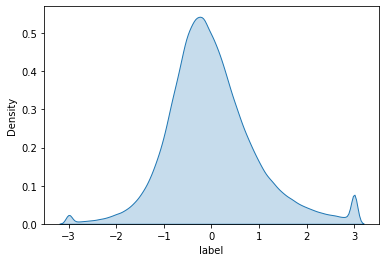

The distribution of y_valid:


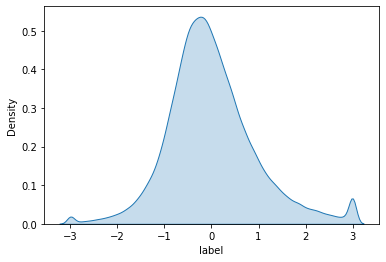

The distribution of y_test:


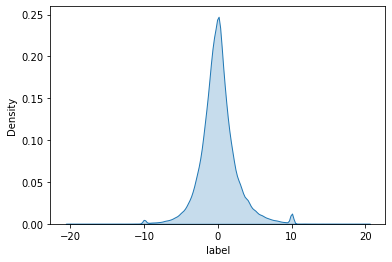

norm data done 

all works done 



In [5]:
split_params = {
    "test_date": "2019-01-01",
    "split_method": "split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

attention = models.Attention(epochs=20)
attention.fit(X_train, y_train, X_valid, y_valid)

pred = attention.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/20
2353/2353 [==============================] - 136s 58ms/step - loss: 1.1015 - mae: 0.7395 - mape: 2112.5503 - val_loss: 1.0096 - val_mae: 0.7121 - val_mape: 1602.3046
Epoch 2/20
2353/2353 [==============================] - 140s 59ms/step - loss: 0.9859 - mae: 0.7065 - mape: 1176.9446 - val_loss: 0.9680 - val_mae: 0.7090 - val_mape: 1016.2915
Epoch 3/20
2353/2353 [==============================] - 135s 57ms/step - loss: 0.9350 - mae: 0.7038 - mape: 874.6545 - val_loss: 0.9222 - val_mae: 0.7114 - val_mape: 1256.6643
Epoch 4/20
2353/2353 [==============================] - 135s 58ms/step - loss: 0.8998 - mae: 0.7030 - mape: 456.4745 - val_loss: 0.8997 - val_mae: 0.7069 - val_mape: 1064.4562
Epoch 5/20
2353/2353 [==============================] - 141s 60ms/step - loss: 0.8911 - mae: 0.7029 - mape: 1068.6554 - val_loss: 0.9046 - val_mae: 0.7079 - val_mape: 2583.8037
Epoch 6/20
2353/2353 [==============================] - 140s 59ms/step - loss: 0.8911 - mae: 0.7028 - mape: 501.2982 

,predict
count,280721.000000
mean,-0.000201
std,0.001985
min,-0.014322
25%,-0.001226
50%,-0.000069
75%,0.000939
max,0.012574


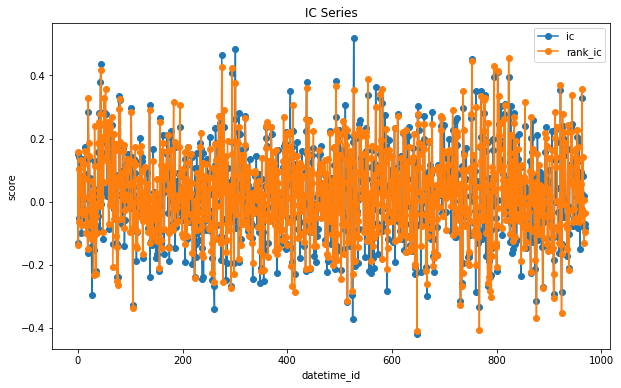

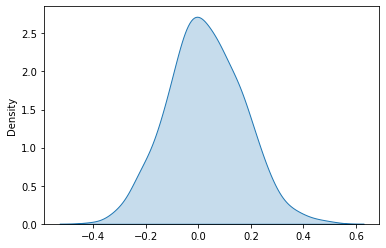

ic= 0.02607435725260284 icir= 0.18039755917162686 rank_ic= 0.029146416448653897 rank_icir= 0.2063712961945621


0.02372906285198103

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [8]:
model = attention.model
# print(model.summary())
model.save("attention")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: attention\assets
